# X-ray CT using CUQIpy and CUQIpy-CIL plugin

[The Core Imaging Library (CIL)](https://www.ccpi.ac.uk/cil) is an open-source python library for processing and reconstruction of CT data (and other inverse problems).


The CUQIpy-CIL plugin wraps CIL tools into CUQIpy, so that CUQIpy can be used to carry out UQ analysis on CT problems.

This notebook first demonstrates how to use the test problems provided by the CUQIpy-CIL plugin and set up and run a CUQIpy UQ analysis.

Next a real X-ray CT data set is loaded in, analyzed and reconstructed using CIL. 

Finally the real data case is set up using the CUQIpy-CIL plugin for UQ analysis.

### Prerequisites
Make sure you have the latest version of CIL and CUQIpy-CIL installed. See install instructions [here](https://github.com/CUQI-DTU/CUQIpy-CIL)

The notebook assumes a general familiarity with CT.

<div style="border: 2px solid #FFB74D; background-color: #FFF3E0; border-radius: 8px; padding: 10px; font-family: Arial, sans-serif; color: #333; box-shadow: 2px 2px 8px rgba(0, 0, 0, 0.1); max-width: 750px; margin: 0 auto;">
  <strong style="color: #E65100;">⚠️ Note:</strong> 
  
- This notebook was run on some machine and not using github actions for this book. To run this notebook on your machine, you need to have [CUQIpy-CIL installed](https://github.com/CUQI-DTU/CUQIpy-CIL).

- This notebook uses MCMC samplers from the new <code>cuqi.experimental.mcmc</code> module, which are expected to become the default soon. Check out the <a href="https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.experimental.mcmc.html#module-cuqi.experimental.mcmc">documentation</a> for more details.

</div>

## 1. CT test problems in the CUQIpy-CIL plugin

We first load the tools we need, including the CUQIpy-CIL plugin `cuqipy_cil`:

In [1]:
import cuqi
import cuqipy_cil
import numpy as np
import matplotlib.pyplot as plt

# For the moment, we stick to CPU only mode using astra
cuqipy_cil.config.PROJECTION_BACKEND = "astra"
cuqipy_cil.config.PROJECTION_BACKEND_DEVICE = "cpu"

Load a CT forward model and data from testproblem, which can be configured. A fan beam test problem is also available.

We stick to a fairly small image size to reduce the computational time for this demo assuming most users will be running this on a laptop with no GPU.

In [2]:
A, y_data, info = cuqipy_cil.testproblem.ParallelBeam2D(
    im_size=(90, 90),
    det_count=128,
    angles=np.linspace(0, np.pi, 90),
    phantom="shepp-logan"
).get_components()

We extract and display the exact solution image, to be reconstructed:

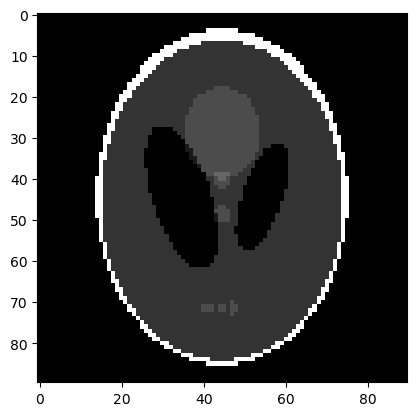

In [3]:
x_exact = info.exactSolution
x_exact.plot()

The data is a sinogram, which we can plot:

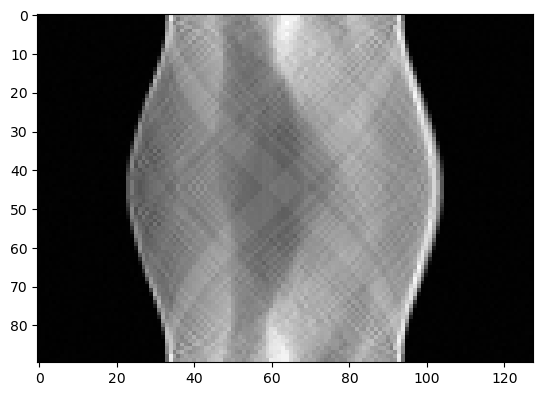

In [4]:
y_data.plot()

Instead of loading the premade noisy sinogram from the test problem we could also have generated it ourselves by forward projecting it using the forward model (and adding noise):

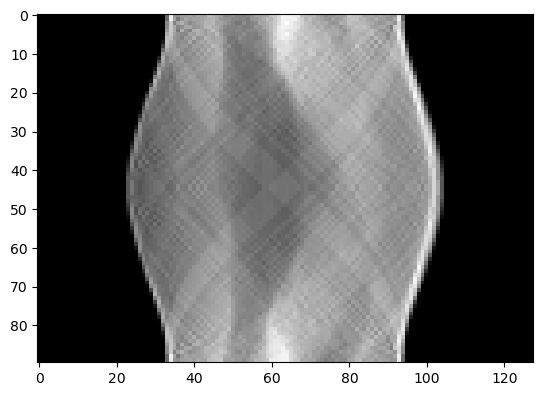

In [5]:
(A@x_exact).plot()

# 2. Setting up and solving a Bayesian inverse problem

As in previous notebooks we can set up a Bayesian model, assuming a Gaussian prior for the image and additive Gaussian noise: 

In [6]:
x = cuqi.distribution.Gaussian(np.zeros(A.domain_dim), cov=1) # x ~ N(0, 1)
y = cuqi.distribution.Gaussian(A@x, cov=0.05**2)              # y ~ N(Ax, 0.05^2)

From the two distributions we can either set up a JointDistribution, condition on the data and sample the posterior, or we can use the higher-level interface BayesianProblem which does all of that for us, including selecting a suitable sampler:

In [7]:
BP = cuqi.problem.BayesianProblem(y, x)
BP.set_data(y=y_data)

BayesianProblem with target: 
 Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI Gaussian.
 )

Sample from the posterior (this will take a few minutes depending on your hardware):

In [8]:
samples = BP.sample_posterior(300, experimental=True)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is a work-in-progress. !!!
!!!       Always validate the computed results.        !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!  Using samplers from cuqi.experimental.mcmc  !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using cuqi.experimental.mcmc LinearRTO sampler.
burn-in: 20%


Sample: 100%|██████████| 300/300 [01:14<00:00,  4.03it/s]

Elapsed time: 88.88283324241638


Analyze the samples:

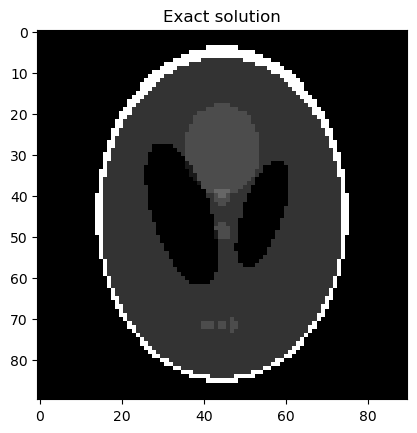

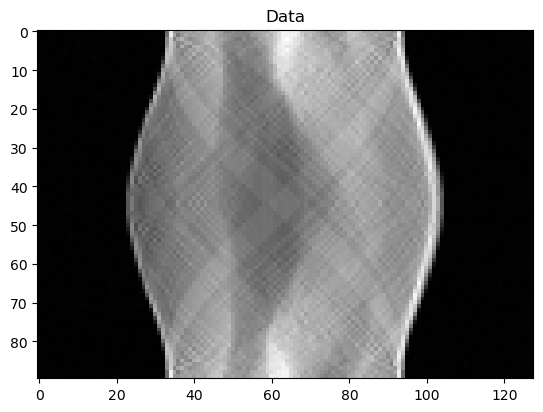

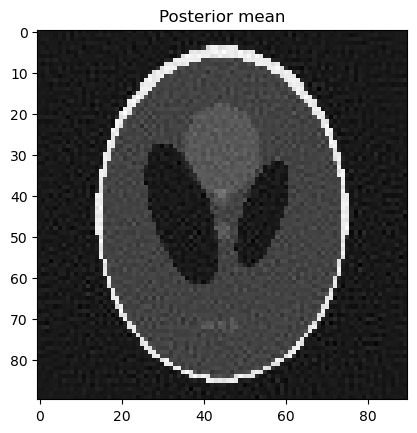

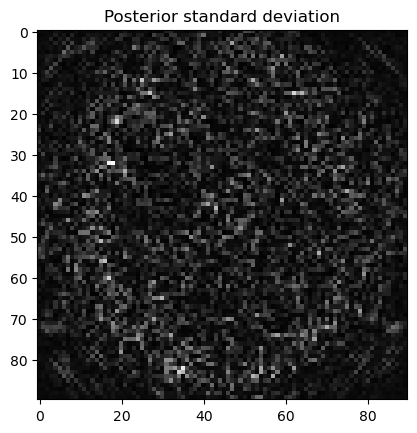

In [9]:
info.exactSolution.plot(); plt.title("Exact solution"); plt.show()
y_data.plot(); plt.title("Data"); plt.show()
samples.plot_mean(); plt.title("Posterior mean"); plt.show()
samples.plot_std(); plt.title("Posterior standard deviation"); plt.show()

Try instead of a Gaussian prior with an edge-preserving Cauchy difference prior:

In [10]:
x = cuqi.distribution.CMRF(location=0, scale=0.01, geometry=A.domain_geometry)
y = cuqi.distribution.Gaussian(A@x, cov=0.05**2)              # y ~ N(Ax, 0.05^2)

In [11]:
BP_C = cuqi.problem.BayesianProblem(y, x)
BP_C.set_data(y=y_data)

BayesianProblem with target: 
 Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI CMRF.
 )

Sampling from this posterior may take a bit longer.

In [12]:
samples_C = BP_C.sample_posterior(300, experimental=True)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is a work-in-progress. !!!
!!!       Always validate the computed results.        !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!  Using samplers from cuqi.experimental.mcmc  !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using cuqi.experimental.mcmc No-U-Turn (NUTS) sampler.
burn-in: 20%


Sample: 100%|██████████| 300/300 [00:49<00:00,  6.09it/s]

Elapsed time: 66.85000872612


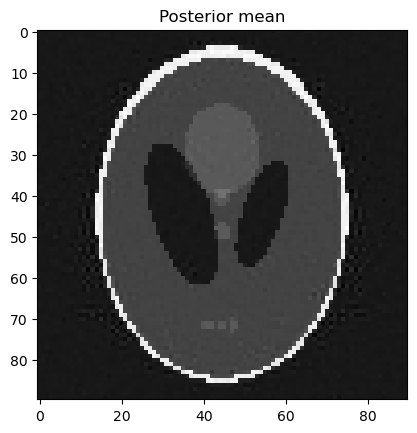

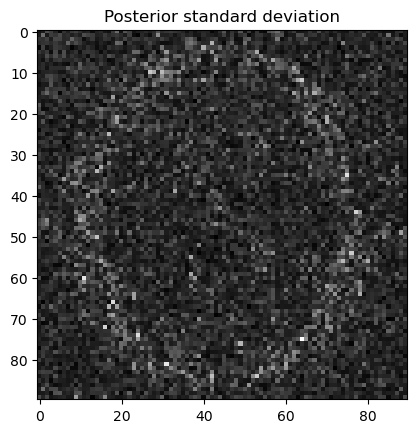

In [13]:
samples_C.plot_mean(); plt.title("Posterior mean"); plt.show()
samples_C.plot_std(); plt.title("Posterior standard deviation"); plt.show()

# 3. Reconstructing a real X-ray CT dataset using CIL

The last part of this notebook focuses on a real X-ray CT data set. The data set is of a Lotus root and is provided by the Finnish Inverse Problems Society. We will first show how to load in and explore this data and set it up for reconstruction using CIL (without CUQIpy). Afterwards it will be shown how to wrap this into CUQIpy and then the task is to carry out some UQ analysis for this data using CUQIpy.

We first load the tools we are going to need:

In [14]:
import scipy
import numpy as np
from cil.framework import AcquisitionData, AcquisitionGeometry
from cil.utilities.display import show2D, show_geometry
from cil.recon import FDK
from cil.plugins.astra.processors import FBP
from cil.processors import Binner
from cil.plugins.astra import ProjectionOperator
from cil.optimisation.algorithms import CGLS

c:\Users\nabr\anaconda3\envs\cil\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Go to https://zenodo.org/record/1254204/ and download the file sinogram.mat to the same directory as this notebook. This is an X-ray data set of a Lotus root, see https://arxiv.org/pdf/1609.07299.pdf for details.

The data can be loaded and cropped according to instructions in the original code accompanying the data:

In [15]:
sinogram = scipy.io.loadmat('sinogram.mat')['sinogram'].T
sinogram = sinogram.astype('float32')
sinogram = sinogram[0:360, 0:2221]

In [16]:
sinogram.shape

(360, 2221)

The parameters needed to specify the scan geometry are provided in the orignal code `Lotus_FBP.m`

In [17]:
num_angles = sinogram.shape[0]
num_dets = sinogram.shape[1]
source_center = 54
source_detector = 63
det_pixel_size = 12/2240

We specify the projection angles:

In [18]:
angles = np.linspace(0, 360, num_angles, endpoint=False)

We create using CIL commands the `AcquisitionGeometry` representing the scan geometry:

In [19]:
ag_full = (
    AcquisitionGeometry.create_Cone2D(
        source_position=[0, -source_center],
        detector_position=[0, source_detector - source_center],
    )
    .set_panel(num_pixels=num_dets, pixel_size=det_pixel_size)
    .set_angles(angles=-angles, angle_unit="degree")
)

And put it in the CIL data structure `AcquisitionData`:

In [20]:
data_full = AcquisitionData(sinogram, geometry=ag_full)

We can take a look at the data by the CIL plot show2D:

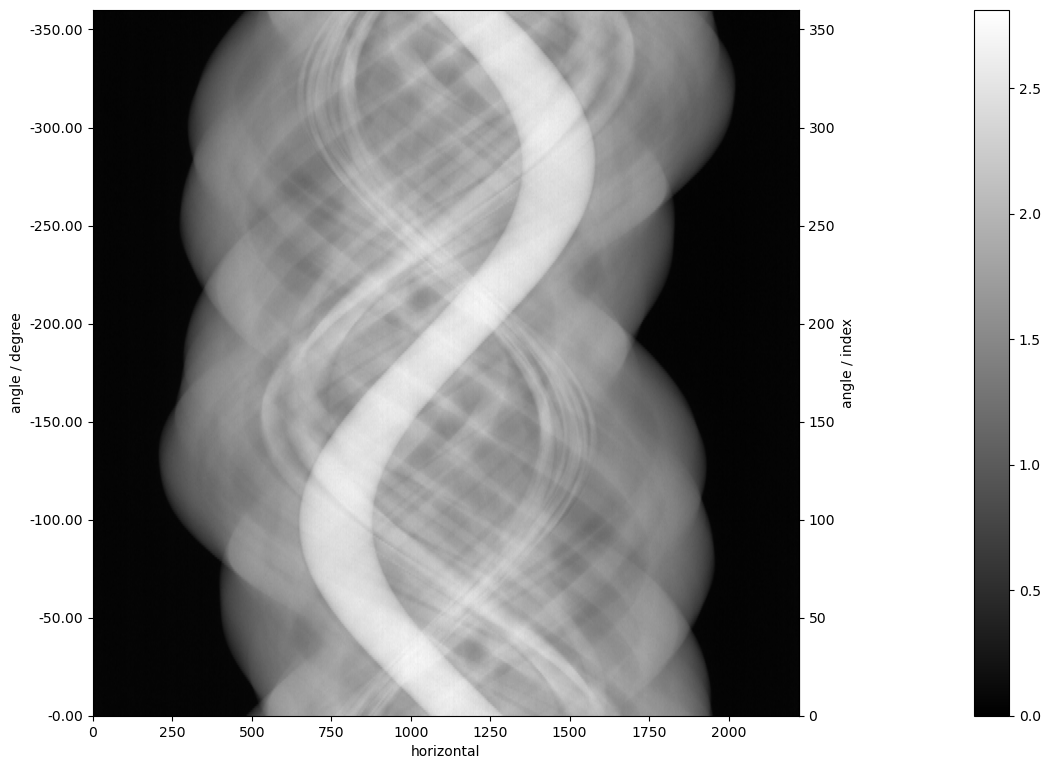

In [21]:
show2D(data_full)

We can take a look at the scan geometry using a CIL plot:

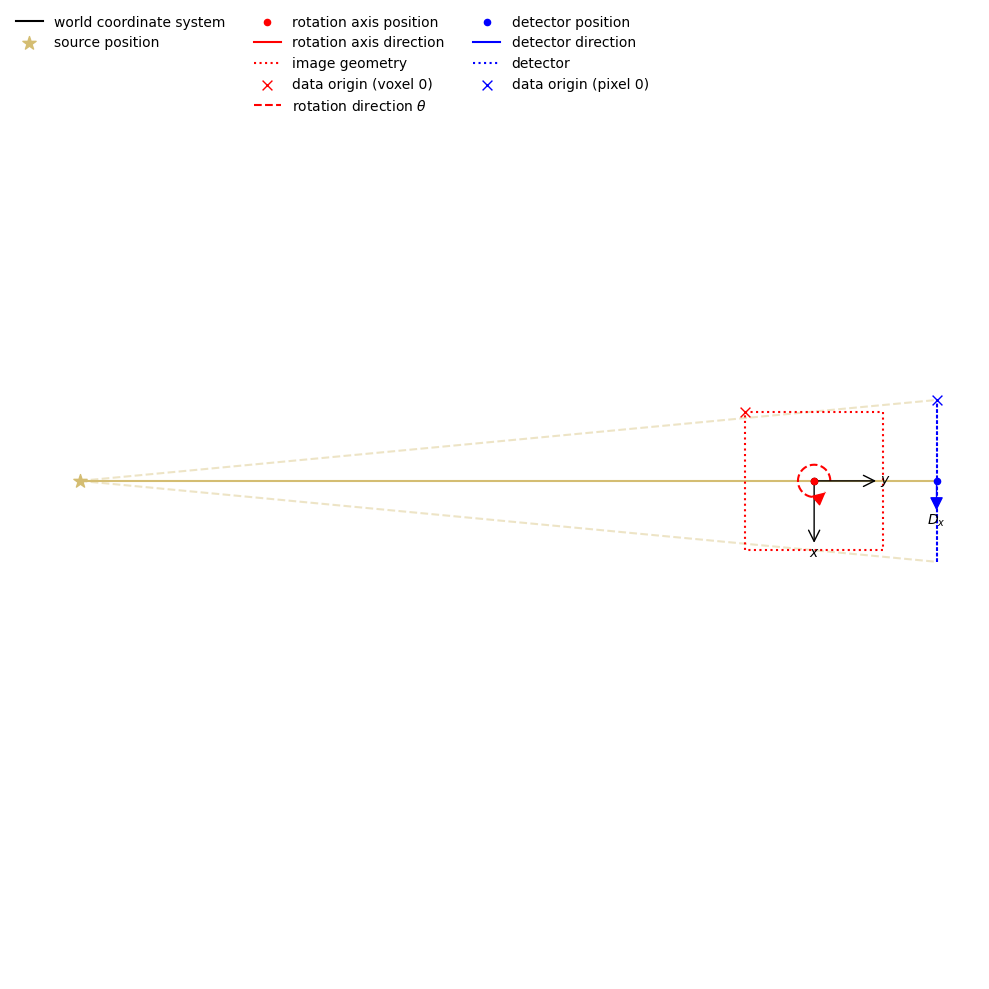

In [22]:
show_geometry(ag_full)

Before proceeding we provide the opportunity to downsample the data to make experiments run faster. Choose an integer factor for the angles and the horizontal detector pixel dimensions:

In [23]:
ds_angle = 1
ds_horizontal = 10

In [24]:
data = Binner(roi={'angle':(0,360,ds_angle),'horizontal':(0,2221,ds_horizontal)})(data_full)
print(data)

Number of dimensions: 2
Shape: (360, 222)
Axis labels: ('angle', 'horizontal')



We extract the acquisition geometry of the downsampled data and can specify the corresponding geometry of the image to be reconstructed onto, here the default choice:

In [25]:
ag = data.geometry
print(ag)

2D Cone-beam tomography
System configuration:
	Source position: [  0., -54.]
	Rotation axis position: [0., 0.]
	Detector position: [-2.67857143e-03,  9.00000000e+00]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [222   1]
	Pixel size: [0.05357143 0.00535714]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 360
	Angles 0-9 in degrees: [-0., -1., -2., -3., -4., -5., -6., -7., -8., -9.]
	Angles 350-359 in degrees: [-350., -351., -352., -353., -354., -355., -356., -357., -358., -359.]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


In [26]:
ig = ag.get_ImageGeometry()
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x222,y222
voxel_size : x0.04591836734693878,y0.04591836734693878
center : x0,y0



Now we can use CIL reconstruction tools. We specify the CIL forward model and use the CGLS algorithm for a basic early-stopping least squares reconstruction:

In [27]:
AP = ProjectionOperator(ig, ag, device='cpu')

In [28]:
cgls = CGLS(operator=AP, data=data, tolerance=-1, max_iteration=1000)

In [29]:
cgls.run(30)

100%|██████████| 30/30 [00:11<00:00,  2.53it/s, objective=64.8]  


We can show the reconstruction, which is held in the reconstruction algorithm's `solution` attribute, using the CIL `show2D` plot:

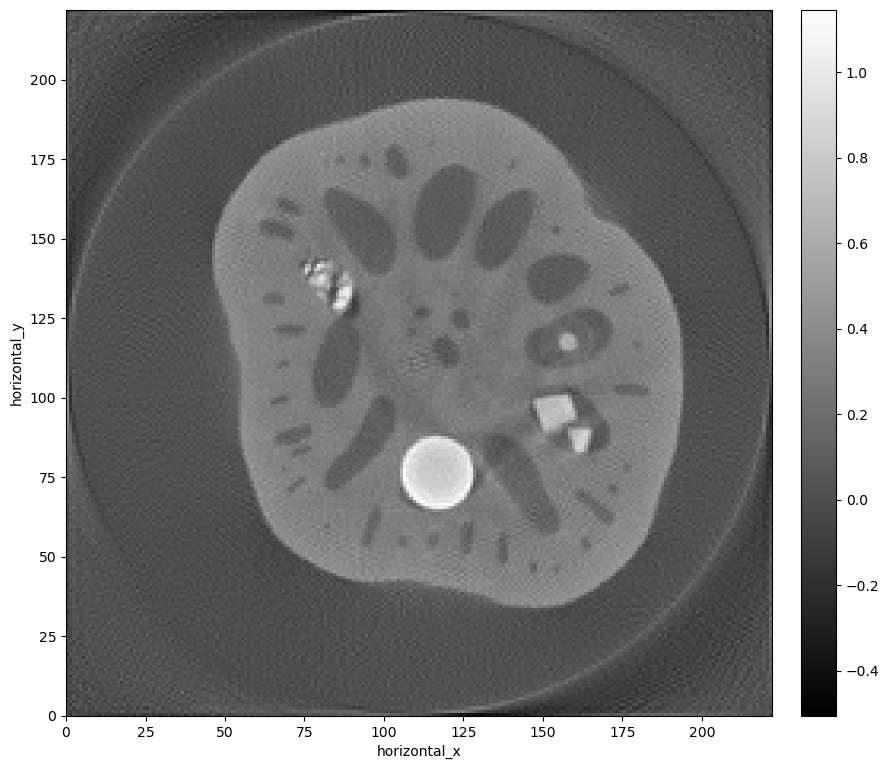

In [30]:
show2D(cgls.solution)

# 4. Wrapping the real data into CUQIpy

The previous section demonstrated how to reconstruct the data using CIL. This section explores how to run UQ on it using CUQIpy. We need a few CUQIpy tools:

In [31]:
from cuqipy_cil.model import CILModel
from cuqi.array import CUQIarray

The CIL acquisition and image geometry fully specify the imaging setup and we can create a CUQIpy CIL forward model directly from these:

In [32]:
model = CILModel(ag, ig)
print(model)

CUQI CILModel: Image2D(49284,) -> Image2D(79920,).
    Forward parameters: ['x'].


Instead of using CIL data structures for the sinogram data we need to use the CUQIpy data structure CUQIarray, where we provide its geometry from the model's range geometry:

In [33]:
data_cuqi = CUQIarray(data.as_array().ravel(), is_par=True, geometry=model.range_geometry)
data_cuqi

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 Image2D(79920,)

Parameters:
 True

Array:
CUQIarray([0.05546827, 0.05233207, 0.05633232, ..., 0.0506965 ,
           0.05168361, 0.04902546], dtype=float32)

We now have all we need to start using CUQIpy for UQ analyzing the data. To demonstrate this, we can see if the CUQIpy plotting is available for the data_cuqi:

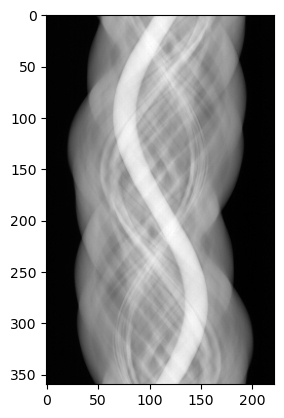

In [34]:
data_cuqi.plot()

As we hoped, this works and gives an Image2D type plot of the sinogram.

We can check that the CUQIpy forward model is working, for example by applying its adjoint operation (corresponding to backprojection) onto the CUQIarray holding the sinogram:

In [35]:
data_backprojected = model.T@data_cuqi
data_backprojected

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 Image2D(49284,)

Parameters:
 True

Array:
CUQIarray([9.061228, 9.090968, 9.260093, ..., 9.96744 , 9.9063  ,
           9.854515], dtype=float32)

And plot the results:

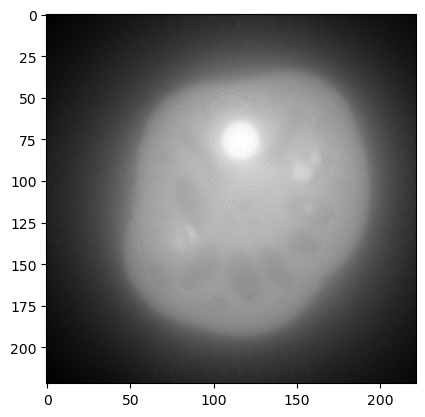

In [36]:
data_backprojected.plot()

As expected a plain backprojection of the sinogram gives a blurry image in the reconstruction domain.

## 5. Open-ended exploration

With the tools in place, you can now explore UQ analysis of the data set, by use of the CUQIpy tools you have met so far.

### Ideas for exploration:

(Can be either for the test problem or the real data)

1. Set up a few-projection case, for example 40 projections (over 180 degrees for parallel-beam or 360 degrees for fan-beam). Explore different priors.
2. Set up a limited angle case, for example instead of full 180-degree data, use 135, 90 or even 45 degree data, and explore different the effect of different priors on the solution and its uncertainty.
3. Try with a smooth phantom instead of a piecewise constant (test problem only)
4. Infer noise level and/or prior precision through Gibbs.

In [37]:
# Your code here



